In [2]:
import cv2
import numpy as np

def visualize_label(image_path, label_path, output_path):
    """
    Visualizes bounding box and keypoints on an image using label file.
    
    Args:
        image_path (str): Path to the input image.
        label_path (str): Path to the label file.
        output_path (str): Path to save the output image with visualizations.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    img_height, img_width, _ = image.shape

    # Read the label file
    with open(label_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        data = line.strip().split(" ")
        
        # Parse bounding box
        class_id = int(data[0])
        bbox_center_x = float(data[1]) * img_width
        bbox_center_y = float(data[2]) * img_height
        bbox_width = float(data[3]) * img_width
        bbox_height = float(data[4]) * img_height
        
        # Calculate bounding box corners
        x_min = int(bbox_center_x - bbox_width / 2)
        y_min = int(bbox_center_y - bbox_height / 2)
        x_max = int(bbox_center_x + bbox_width / 2)
        y_max = int(bbox_center_y + bbox_height / 2)
        
        # Draw the bounding box
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(image, f"Class {class_id}", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Parse keypoints
        keypoints = data[5:]  # Remaining data are keypoints
        for i in range(0, len(keypoints), 3):
            x = float(keypoints[i]) * img_width
            y = float(keypoints[i + 1]) * img_height
            visibility = int(keypoints[i + 2])
            
            # Draw keypoints
            if visibility == 2:  # Only visible keypoints
                cv2.circle(image, (int(x), int(y)), 5, (0, 0, 255), -1)
            elif visibility == 1:  # Occluded keypoints (optional handling)
                cv2.circle(image, (int(x), int(y)), 5, (255, 0, 0), -1)
    
    # Save the output image
    cv2.imwrite(output_path, image)
    print(f"Visualization saved to {output_path}")

# Example usage
image_path = "frame39-SINGLE_jpeg.rf.a8653e267cd3246b1271b0fa0105be44.jpg"  # Replace with your image path
label_path = "frame39-SINGLE_jpeg.rf.a8653e267cd3246b1271b0fa0105be44.txt"  # Replace with your label file path
output_path = "output_frame39.jpg"  # Replace with desired output path

visualize_label(image_path, label_path, output_path)


Visualization saved to output_frame39.jpg


In [3]:
import pickle

with open("dataset/val/labels.cache", "rb") as f:
    cache_data = pickle.load(f)

# Print the first few entries
for key, value in list(cache_data.items())[:5]:  # Show only 5 items
    print(f"{key}: {value}")



UnpicklingError: unpickling stack underflow

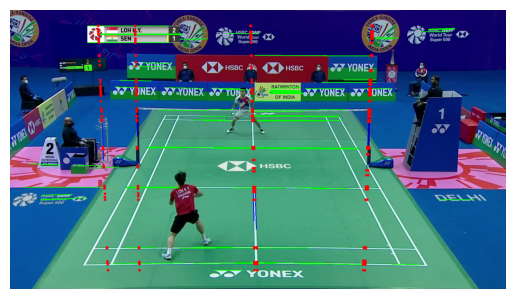

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return blurred

def detect_edges(image):
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    return edges

def detect_lines(edges):
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80, minLineLength=100, maxLineGap=10)
    return lines

def filter_lines(lines):
    vertical_lines = []
    horizontal_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        if -10 <= angle <= 10:  # Horizontal lines
            horizontal_lines.append(line[0])
        elif 80 <= angle <= 100 or -100 <= angle <= -80:  # Vertical lines
            vertical_lines.append(line[0])
    return horizontal_lines, vertical_lines

def compute_intersections(horizontal_lines, vertical_lines):
    intersections = []
    for h_line in horizontal_lines:
        for v_line in vertical_lines:
            x1, y1, x2, y2 = h_line
            x3, y3, x4, y4 = v_line
            denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if denom != 0:
                px = ((x1*y2 - y1*x2) * (x3 - x4) - (x1 - x2) * (x3*y4 - y3*x4)) / denom
                py = ((x1*y2 - y1*x2) * (y3 - y4) - (y1 - y2) * (x3*y4 - y3*x4)) / denom
                intersections.append((int(px), int(py)))
    return intersections

def validate_court(intersections):
    # Implement geometric validation based on court dimensions and aspect ratio
    # This is a placeholder for the actual validation logic
    if len(intersections) >= 4:
        return True
    return False

def draw_lines_and_corners(image, horizontal_lines, vertical_lines, intersections):
    for line in horizontal_lines:
        x1, y1, x2, y2 = line
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    for line in vertical_lines:
        x1, y1, x2, y2 = line
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    for point in intersections:
        cv2.circle(image, point, 5, (0, 0, 255), -1)
    return image

def main(image_path):
    image = cv2.imread(image_path)
    preprocessed = preprocess_image(image)
    edges = detect_edges(preprocessed)
    lines = detect_lines(edges)
    if lines is not None:
        horizontal_lines, vertical_lines = filter_lines(lines)
        intersections = compute_intersections(horizontal_lines, vertical_lines)
        if validate_court(intersections):
            result_image = draw_lines_and_corners(image, horizontal_lines, vertical_lines, intersections)
            plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
        else:
            print("Court validation failed.")
    else:
        print("No lines detected.")

if __name__ == "__main__":
    main('input_videos/image.jpg')



In [9]:
from inference_sdk import InferenceHTTPClient

CLIENT = InferenceHTTPClient(
    api_url="https://outline.roboflow.com",
    api_key="hvPnBUxnbQj5nSsCJCV0"
)

result = CLIENT.infer(your_image.jpg, model_id="badminton-court-detection-cfgah/3")

ModuleNotFoundError: No module named 'inference_sdk'

In [1]:
pip install ultralytics


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch

# Load the YOLOv5 model (e.g., yolov5s, yolov5m, yolov5l, yolov5x)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


c:\Users\adria\Desktop\Tennis\badminton\Lib\site-packages\torch\hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\adria/.cache\torch\hub\master.zip
YOLOv5  2025-3-20 Python-3.12.4 torch-2.5.1+cpu CPU

100%|██████████| 14.1M/14.1M [00:02<00:00, 5.89MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [7]:
# Load video
video_path = "input.mp4"  # Replace with your video file
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define output video codec and writer
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLOv5 inference
    results = model(frame)

    # Render results on frame
    for pred in results.xyxy[0]:  # Iterate through detections
        x1, y1, x2, y2, conf, cls = pred.tolist()
        label = f"{model.names[int(cls)]} {conf:.2f}"
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Write frame to output video
    out.write(frame)

    # Display output (optional)
    cv2.imshow("YOLOv5 Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [4]:
!pip install opencv-python


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


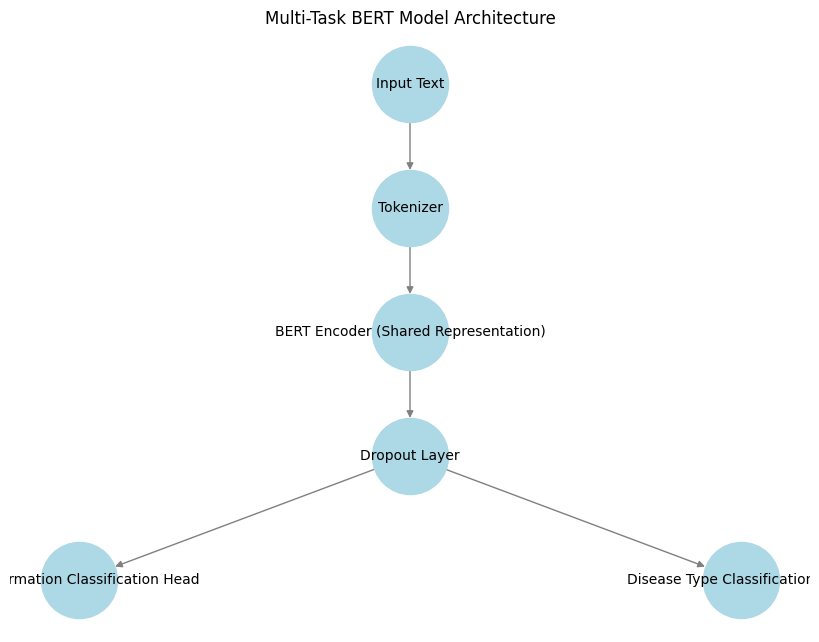

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the model architecture components
nodes = [
    "Input Text", "Tokenizer", "BERT Encoder (Shared Representation)", 
    "Dropout Layer", "Misinformation Classification Head", "Disease Type Classification Head"
]

edges = [
    ("Input Text", "Tokenizer"),
    ("Tokenizer", "BERT Encoder (Shared Representation)"),
    ("BERT Encoder (Shared Representation)", "Dropout Layer"),
    ("Dropout Layer", "Misinformation Classification Head"),
    ("Dropout Layer", "Disease Type Classification Head")
]

# Create a directed graph
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Set node positions
pos = {
    "Input Text": (0, 5), "Tokenizer": (0, 4),
    "BERT Encoder (Shared Representation)": (0, 3),
    "Dropout Layer": (0, 2),
    "Misinformation Classification Head": (-1, 1),
    "Disease Type Classification Head": (1, 1)
}

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=10)
plt.title("Multi-Task BERT Model Architecture")
plt.show()
